# Python API for Mitsuba
The [Mitsuba](http://www.mitsuba-renderer.org/) rendering system exposes many of the C++ API calls to Python access. This notebook includes the examples from the Mitsuba documentation as well as some additional examples for composing and rendering a scene from Python.

Documentation for the [Mitsuba Python bindings](http://www.mitsuba-renderer.org/api/group__libpython.html) is available at the Mitsuba website.

Note that this notebook runs on the assumption that there is a local installation of Mitsuba and that it is compiled in the normal RGB (SPECTRUM_SAMPLES = 3) mode. Full integration with *MORTICIA* requires that Mitsuba be compiled with 4 or more spectral channels in order to put Mitusba into the absolute radiometric mode. "Field" integrators are not available when Mitsuba is compiled with SPECTRUM_SAMPLES > 3. The field integrators are illustrated in this notebook, including distance, normals, UV-mapping coordinates are more. These integrators can be accessed using the Mitsuba "multichannel" integrator facility.

The recommended approach is that the local copy of Mitsuba be compiled with SPECTRUM_SAMPLES = 3 for the use of field integrators and that additional compute platforms be available with Mitsuba compiled having SPECTRUM_SAMPLES > 3.

In [88]:
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import morticia.rad.radute as radute
%matplotlib inline
# Now import the mitsuba Python extension
# The following applies only to Windows
# Configure the search path for the Python extension module
sys.path.append('D:/Projects/MORTICIA/Render/Mitsuba 0.5.0/python/2.7')
# Ensure that Python will be able to find the Mitsuba core libraries
os.environ['PATH'] = 'D:/Projects/MORTICIA/Render/Mitsuba 0.5.0' + os.pathsep + os.environ['PATH']
# On other platforms, measures may also be required to ensure that Python can find the Mitsuba package
import mitsuba
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.radute
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Accessing Core Funcions

In [3]:
# A simple 3-vector transformation operation
from mitsuba.core import *
# Create a normalized direction vector
myVector = normalize(Vector(1.0, 2.0, 3.0))
# 90 deg. rotation around the Y axis
trafo = Transform.rotate(Vector(0, 1, 0), 90)
# Apply the rotation and display the result
print(trafo * myVector)

[0.801784, 0.534522, -0.267261]


## Loading a Scene
Scenes are loaded using the file resolver to find he .xml scene file and then the [SceneHandler](http://www.mitsuba-renderer.org/api/classmitsuba_1_1_scene_handler.html) to load the scene.

Here, the scene cubi.xml contains a CUBI object used in thermal signatorics.

In [4]:
from mitsuba.core import *
from mitsuba.render import SceneHandler
# Get a reference to the thread's file resolver
fileResolver = Thread.getThread().getFileResolver()
# Register any searchs path needed to load scene resources (optional)
fileResolver.appendPath('./examples/Mitsuba/')
# Optional: supply parameters that can be accessed
# by the scene (e.g. as $myParameter)
paramMap = StringMap()
paramMap['myParameter'] = 'value'

In [125]:
# Load the scene from an XML file
scene = SceneHandler.loadScene(fileResolver.resolve("./examples/Mitsuba/cubi.xml"), paramMap)
scene.setDestinationFile('cubiEXR')  # Set the name of the render output file
# Display a textual summary of the scene's contents
print(scene)

Scene[
  sensor = ref<PerspectiveCameraImpl>[ref=2, ptr=PerspectiveCamera[
    xfov = 40,
    nearClip = 0.01,
    farClip = 10000,
    worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
      -0.707107, -0.235706, -0.666665, 2.12711;
      -0.707107, 0.235706, 0.666665, -2.12711;
      0, 0.942807, -0.333339, 1.06356;
      0, 0, 0, 1
    ]],
    sampler = IndependentSampler[
      sampleCount = 1
    ],
    film = HDRFilm[
      size = [1024, 768],
      fileFormat = 1,
      pixelFormat = rgb, luminance, rgb, 
      channelNames = "normal.R", "normal.G", "normal.B", "distance.Y", "uv.R", "uv.G", "uv.B", 
      componentFormat = float32,
      cropOffset = [0, 0],
      cropSize = [1024, 768],
      banner = 1,
      filter = GaussianFilter[stddev=0.500000, radius=2.000000]
    ],
    medium = ref<Medium>[null],
    shutterOpen = 0,
    shutterOpenTime = 0
  ]],
  sampler = ref<IndependentSampler>[ref=2, ptr=IndependentSampler[
    sampleCount = 1
  ]],
  integrator = ref<

## Rendering a Scene
First the scheduler and workers are set up and then the render job is submitted to a job queue. The queue should be set up only once per host.

In [6]:
# Run this only once per session
from mitsuba.render import RenderQueue, RenderJob
import multiprocessing
scheduler = Scheduler.getInstance()
# Start up the scheduling system with one worker per local core
for i in range(0, multiprocessing.cpu_count()):
    scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))
scheduler.start()
# Create a queue for tracking render jobs
queue = RenderQueue()

In [119]:
# Create a render job and insert it into the queue
job = RenderJob('myRenderJob', scene, queue)
job.start()
# Wait for all jobs to finish and release resources
queue.waitLeft(0)
queue.join()
# Print some statistics about the rendering process
print(Statistics.getInstance().getStats())

------------------------------------------------------------
 * Loaded plugins :
    -  plugins\diffuse.dll [Smooth diffuse BRDF]
    -  plugins\envmap.dll [Environment map]
    -  plugins\field.dll [Field extraction integrator]
    -  plugins\gaussian.dll [Gaussian reconstruction filter]
    -  plugins\halton.dll [Halton QMC sampler]
    -  plugins\hdrfilm.dll [High dynamic range film]
    -  plugins\independent.dll [Independent sampler]
    -  plugins\lanczos.dll [Lanczos Sinc filter]
    -  plugins\ldrfilm.dll [Low dynamic range film]
    -  plugins\mfilm.dll [MATLAB / Mathematica / NumPy film]
    -  plugins\multichannel.dll [Multi-channel integrator]
    -  plugins\path.dll [MI path tracer]
    -  plugins\perspective.dll [Perspective camera]
    -  plugins\rectangle.dll [Rectangle intersection primitive]
    -  plugins\sky.dll [Skylight emitter]
    -  plugins\sphere.dll [Sphere intersection primitive]
    -  plugins\sunsky.dll [Sun & sky emitter]

  * General :
    -  Normal rays

In [120]:
# Read the data resulting from the Mitsuba run
channel_names, im_dict, header = radute.readOpenEXR('cubiEXR.exr')
# Print keys of what came back in the image dictionary
print im_dict.keys()

['normal', 'normal.G', 'uv.R', 'uv', 'distance.Y', 'normal.B', 'uv.B', 'uv.G', 'normal.R']


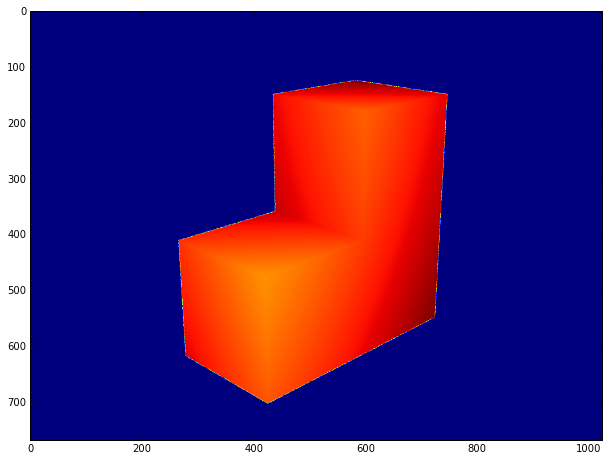

In [121]:
# Plot the distance data
plt.figure(figsize=(10.24, 7.68))
plt.imshow(im_dict['distance.Y'])

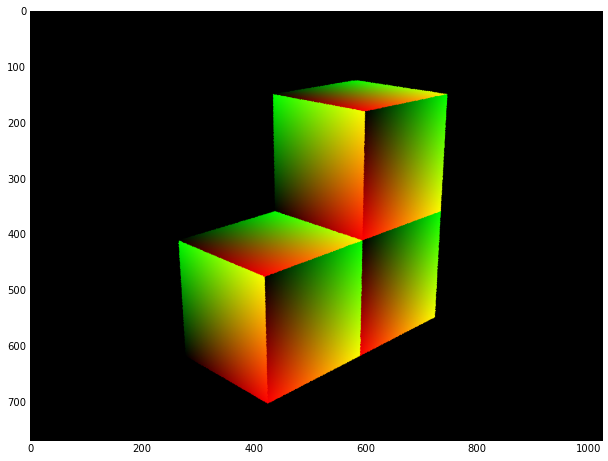

In [122]:
# Plot the UV data (u, v coordinates on each pixel hit)
plt.figure(figsize=(10.24, 7.68))
plt.imshow(im_dict['uv'])

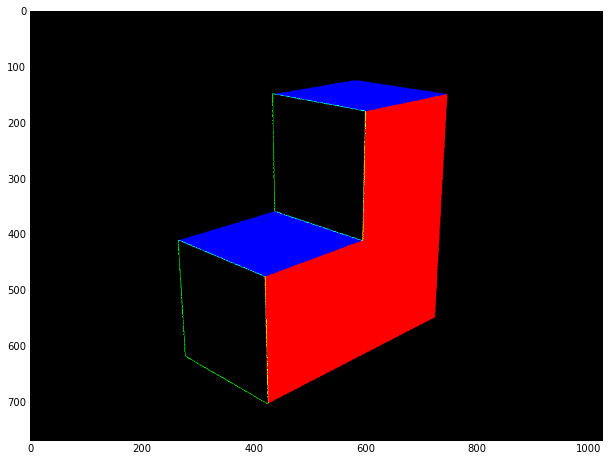

In [123]:
# Plot the UV data (u, v coordinates on each pixel hit)
plt.figure(figsize=(10.24, 7.68))
plt.imshow(im_dict['normal'])

In [124]:
# Take a look at the CUBI
cubi_img = mpimg.imread('cubiPNG.png')
plt.figure(figsize=(10.24, 7.68))
plt.imshow(cubi_img)

IOError: [Errno 2] No such file or directory: 'cubiPNG.png'

In [5]:
# Load the material preview scene from an XML file
mat_scene = SceneHandler.loadScene(fileResolver.resolve("./examples/Mitsuba/matpreview.xml"))
mat_scene.setDestinationFile('mat_ball')  # Set the name of the render output file
# Display a textual summary of the scene's contents
print(mat_scene)

Scene[
  sensor = ref<PerspectiveCameraImpl>[ref=2, ptr=PerspectiveCamera[
    xfov = 37.8664,
    nearClip = 0.01,
    farClip = 10000,
    worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
      -0.685884, -0.317366, -0.654861, 3.69558;
      -0.727631, 0.312466, 0.610671, -3.46243;
      0.0108156, 0.895346, -0.44524, 3.25463;
      0, 0, 0, 1
    ]],
    sampler = LowDiscrepancySampler[
      sampleCount = 64,
      dimension = 4
    ],
    film = HDRFilm[
      size = [683, 512],
      fileFormat = 1,
      pixelFormat = rgb, 
      channelNames = "R", "G", "B", 
      componentFormat = float16,
      cropOffset = [0, 0],
      cropSize = [683, 512],
      banner = 0,
      filter = GaussianFilter[stddev=0.500000, radius=2.000000]
    ],
    medium = ref<Medium>[null],
    shutterOpen = 0,
    shutterOpenTime = 0
  ]],
  sampler = ref<LowDiscrepancySampler>[ref=2, ptr=LowDiscrepancySampler[
    sampleCount = 64,
    dimension = 4
  ]],
  integrator = ref<MIPathTracer>[

In [8]:
# Create a render job and insert it into the queue
job = RenderJob('myRenderJob', mat_scene, queue)
job.start()
# Wait for all jobs to finish and release resources
queue.waitLeft(0)
queue.join()


In [17]:
# Perform the animation run
mat_sensor = mat_scene.getSensor()
mat_sensor.setShutterOpen(0)
mat_sensor.setShutterOpenTime(1)
stepSize = 5
for i in range(0,360 / stepSize):
    rotationCur = Transform.rotate(Vector(0, 0, 1), i*stepSize)
    rotationNext = Transform.rotate(Vector(0, 0, 1), (i+1)*stepSize)
    trafoCur = Transform.lookAt(rotationCur * Point(0,-6,4),
        Point(0, 0, .5), rotationCur * Vector(0, 1, 0))
    trafoNext = Transform.lookAt(rotationNext * Point(0,-6,4),
        Point(0, 0, .5), rotationNext * Vector(0, 1, 0))
    atrafo = AnimatedTransform()
    atrafo.appendTransform(0, trafoCur)
    atrafo.appendTransform(1, trafoNext)
    atrafo.sortAndSimplify()
    mat_sensor.setWorldTransform(atrafo)
    mat_scene.setDestinationFile('frame_%03i.png' % i)
    job = RenderJob('job_%i' % i, mat_scene, queue)
    job.start()
    queue.waitLeft(0)

In [10]:
# Release resources
queue.join()


# Creating a Scene
The first example from the Mitsuba manual on scene construction shows how to build a sensor with a film.

First a generic plugin manager is created and then a plugin instance of specific type is assigned, in this case a perspective camera with HD film.

In [6]:
from mitsuba.render import Scene
pmgr = PluginManager.getInstance()  # Get generic plugin manager instance
# Encodes parameters on how to instantiate the 'perspective' plugin
sensorProps = Properties('perspective')
sensorProps['toWorld'] = Transform.lookAt(
    Point(0, 0, -10), # Camera origin
    Point(0, 0, 0), # Camera target
    Vector(0, 1, 0) # 'up' vector
    )
sensorProps['fov'] = 45.0
# Encodes parameters on how to instantiate the 'ldrfilm' plugin
filmProps = Properties('ldrfilm')
filmProps['width'] = 1920
filmProps['height'] = 1080
# Load and instantiate the plugins
sensor = pmgr.createObject(sensorProps)
film = pmgr.createObject(filmProps)
# First configure the film and then add it to the sensor
film.configure()
sensor.addChild('film', film)
# Now, the sensor can be configured
sensor.configure()
# Print the sensor
sensor

PerspectiveCamera[
  xfov = 45,
  nearClip = 0.01,
  farClip = 10000,
  worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
    1, 0, 0, 0;
    0, 1, 0, 0;
    0, 0, 1, -10;
    0, 0, 0, 1
  ]],
  sampler = IndependentSampler[
    sampleCount = 4
  ],
  film = LDRFilm[
    size = [1920, 1080],
    fileFormat = 0,
    pixelFormat = rgb,
    gamma = -1,
    cropOffset = [0, 0],
    cropSize = [1920, 1080],
    banner = 1,
    method = gamma,
    exposure = 0,
    reinhardKey = 0.18,
    reinhardBurn = 0,
    filter = GaussianFilter[stddev=0.500000, radius=2.000000]
  ],
  medium = ref<Medium>[null],
  shutterOpen = 0,
  shutterOpenTime = 0
]

## Creating a Scene using Dictionaries
The following cell shows how to do the same sensor/film creation using dictionaries instead. This sensor/film has the same properties as that created in the previous cell.

In [7]:
pmgr = PluginManager.getInstance()
sensor = pmgr.create({
    'type' : 'perspective',
    'toWorld' : Transform.lookAt(
        Point(0, 0, -10),
        Point(0, 0, 0),
        Vector(0, 1, 0)
    ),
    'film' : {
        'type' : 'ldrfilm',
        'width' : 1920,
        'height' : 1080
    }
})
# Now, the sensor can be configured
sensor.configure()

In [8]:
# Print out the sensor plugin instance
# Note how there are considerably more properties that has been given default values
sensor

PerspectiveCamera[
  xfov = 41.323,
  nearClip = 0.01,
  farClip = 10000,
  worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
    1, 0, 0, 0;
    0, 1, 0, 0;
    0, 0, 1, -10;
    0, 0, 0, 1
  ]],
  sampler = IndependentSampler[
    sampleCount = 4
  ],
  film = LDRFilm[
    size = [1920, 1080],
    fileFormat = 0,
    pixelFormat = rgb,
    gamma = -1,
    cropOffset = [0, 0],
    cropSize = [1920, 1080],
    banner = 1,
    method = gamma,
    exposure = 0,
    reinhardKey = 0.18,
    reinhardBurn = 0,
    filter = GaussianFilter[stddev=0.500000, radius=2.000000]
  ],
  medium = ref<Medium>[null],
  shutterOpen = 0,
  shutterOpenTime = 0
]

## Full Scene Creation
The previous examples only provided snippets of a scene. The following is a full scene creation example from the Mitsuba manual.

In [19]:
full_scene = Scene()
# Create a sensor, film & sample generator
full_scene.addChild(pmgr.create({
    'type' : 'perspective',
    'toWorld' : Transform.lookAt(
        Point(0, 0, -10),
        Point(0, 0, 0),
        Vector(0, 1, 0)
    ),
    'film' : {
        'type' : 'ldrfilm',
                'width' : 1920,
                'height' : 1080
    },
    'sampler' : {
        'type' : 'ldsampler',
        'sampleCount' : 2
    }
}))
# Set the integrator
full_scene.addChild(pmgr.create({
    'type' : 'path'
}))
# Add a light source
full_scene.addChild(pmgr.create({
    'type' : 'point',
    'position' : Point(5, 0, -10),
    'intensity' : Spectrum(100)
}))
# Add a shape
full_scene.addChild(pmgr.create({
    'type' : 'sphere',
    'center' : Point(0, 0, 0),
    'radius' : 1.0,
    'bsdf' : {
        'type' : 'diffuse',
        'reflectance' : Spectrum(0.4)
    }
}))
full_scene.setDestinationFile('ball')  # Set the name of the render output file
# By default, the output file will be a .png
full_scene.configure()

In [20]:
# Render the full scene just created using the existing job queus
job = RenderJob('myRenderJob', full_scene, queue)
job.start()
# Wait for all jobs to finish and release resources
queue.waitLeft(0)
queue.join()
# Print some statistics about the rendering process
print(Statistics.getInstance().getStats())

------------------------------------------------------------
 * Loaded plugins :
    -  plugins\diffuse.dll [Smooth diffuse BRDF]
    -  plugins\direct.dll [Direct illumination integrator]
    -  plugins\envmap.dll [Environment map]
    -  plugins\gaussian.dll [Gaussian reconstruction filter]
    -  plugins\halton.dll [Halton QMC sampler]
    -  plugins\hdrfilm.dll [High dynamic range film]
    -  plugins\independent.dll [Independent sampler]
    -  plugins\lanczos.dll [Lanczos Sinc filter]
    -  plugins\ldrfilm.dll [Low dynamic range film]
    -  plugins\ldsampler.dll [Low discrepancy sampler]
    -  plugins\path.dll [MI path tracer]
    -  plugins\perspective.dll [Perspective camera]
    -  plugins\point.dll [Point emitter]
    -  plugins\rectangle.dll [Rectangle intersection primitive]
    -  plugins\sky.dll [Skylight emitter]
    -  plugins\sphere.dll [Sphere intersection primitive]
    -  plugins\sunsky.dll [Sun & sky emitter]

  * General :
    -  Normal rays traced : 267.325 M


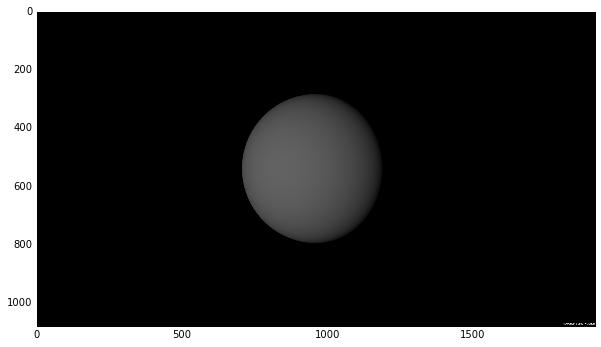

In [21]:
# Show the result
ball_img = mpimg.imread('ball.png')
plt.figure(figsize=(10, 5.625))
plt.imshow(ball_img)